<a href="https://colab.research.google.com/github/mittalchirag/EVA/blob/master/Assignment-7/Assignment_7B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#import all the essential libraries

import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
import keras
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Lambda, concatenate, Conv2D, Convolution2D, Input, SeparableConv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Concatenate
from keras.optimizers import Adam
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from keras.layers.merge import concatenate

# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
from keras import backend as k

# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

from keras.utils import np_utils

In [2]:
#import cifar 10 dataset
from keras.datasets import cifar10
#split into test and train
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
#load image height, width, channels
img_height, img_width, channel = train_features.shape[1],train_features.shape[2],train_features.shape[3]
#load img channels, rows, cols, and samples
num_train, img_channels, img_rows, img_cols =  train_features.shape
#load test features shape
num_test, _, _, _ =  test_features.shape
#count number of labels 
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 9s 0us/step


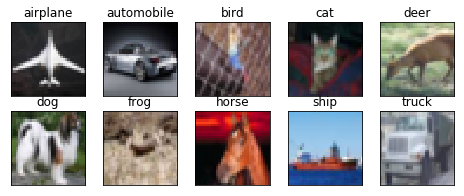

In [3]:
#label names
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
#Plot an image of each label
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
#function to plot model history - accuracy, loss
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
#function to return test accuracy
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

### Function for space to depth conversion

In [0]:
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)

### Functional ENAS Network

In [10]:
#Define ENAS Model


Input_Shape = Input(shape=(32, 32, 3))

#Depthwise Separable Convolution : Depth-wise convolution followed by point-wise
layer1 = SeparableConv2D(32, 5, padding='same', name='SepConv_01')(Input_Shape)   #Input size 32x32
layer1 = BatchNormalization(name='BN_01')(layer1)
layer1 = Activation('relu', name='relu_01')(layer1)

#Skip Connection Layer-1
skip_connect_l1 = layer1              #Input to layer 4,6,8,10,MaxPool-1,MaxPool-2

#Normal Convolution
layer2 = Conv2D(32, (5, 5), padding='same', name='Conv_02')(layer1)              #Input size 32x32
layer2 = BatchNormalization(name='BN_02')(layer2)
layer2 = Activation('relu', name='relu_02')(layer2)

#Skip Connection Layer-2
skip_connect_l2 = layer2              #Input to layer 10,11

#Normal Convolution
layer3 = Conv2D(32, (5, 5), padding='same', name='Conv_03')(layer2)              #Input size 32x32
layer3 = BatchNormalization(name='BN_03')(layer3)
layer3 = Activation('relu', name='relu_03')(layer3)

#Skip Connection Layer-3
skip_connect_l3 = layer3              #Input to layer 7,8,11,12
 
#Concatation of Layers (1, Layer-3) for Layer-4
layer3 = concatenate ([layer3, skip_connect_l1], axis=-1)

#Depthwise Separable Convolution : Depth-wise convolution followed by point-wise
layer4 = SeparableConv2D(32, 5, padding='same', name='SepConv_04')(layer3)       #Input size 32x32
layer4 = BatchNormalization(name='BN_04')(layer4)
layer4 = Activation('relu', name='relu_04')(layer4)

#Skip Connection Layer-4
skip_connect_l4 = layer4              #Input to layer 6,7,8,10,12,MP2,Softmax

#Add Skip Layer-1 to Maxpool-1 
layer4 = concatenate ([layer4, skip_connect_l1],axis=-1)

#MaxPooling Layer-1
maxpoolLayer1 = MaxPooling2D(pool_size=(2,2))(layer4)
maxpoolLayer1 = Lambda(space_to_depth_x2)(maxpoolLayer1)
maxpoolLayer1 = Conv2D(32, (1, 1), padding='same', name='maxpoolLayer1')(layer4)

#Depthwise Separable Convolution : Depth-wise convolution followed by point-wise
layer5 = SeparableConv2D(32, 3, padding='same', name='SepConv_05')(maxpoolLayer1)    #Input size 16x16
layer5 = BatchNormalization(name='BN_05')(layer5)
layer5 = Activation('relu', name='relu_05')(layer5)
layer5 = Lambda(space_to_depth_x2)(layer5)
layer5 = Conv2D(32, (1, 1), padding='same', name='layer5')(layer5)

#Skip Connection Layer-5
skip_connect_l5 = layer5               #Input to layer 7,8,11,12,MP2

#Add Skip Layer-1 to Layer-6 
skip_con1To6 = Lambda(space_to_depth_x2)(skip_connect_l1)

#Add Skip Layer-4 to Layer-6 
skip_con4To6 = Lambda(space_to_depth_x2)(skip_connect_l4)

#Concatation of Layers (1, 4 and Layer-5) for Layer-6
layer5 = concatenate ([layer5, skip_con1To6, skip_con4To6], axis=-1)

#Normal Convolution
layer6 = Conv2D(32, (5, 5), padding='same', name='Conv_06')(layer5)                 #Input size 16x16
layer6 = BatchNormalization(name='BN_06')(layer6)
layer6 = Activation('relu', name='relu_06')(layer6)

#Skip Connection Layer-6
skip_connect_l6 = layer6                #Input to layer 8,9

# add Skip Layer 3 to 7 
skip_con3To7 = Lambda(space_to_depth_x2)(skip_connect_l3)
skip_con3To7 = Conv2D(32, (1, 1), padding='same', name='skip_con3To7_1x1')(skip_con3To7)

# add Skip Layer 4 to 7 
skip_con4To7 = Lambda(space_to_depth_x2)(skip_connect_l4)
skip_con4To7 = Conv2D(32, (1, 1), padding='same', name='skip_con4To7_1x1')(skip_con4To7)

# add Skip Layer 5 to 7 
skip_con5To7 = skip_connect_l5
skip_con5To7 = Conv2D(32, (1, 1), padding='same', name='skip_con5To7_1x1')(skip_con5To7)

#Concatation of Layers (3, 4, 5, and Layer-6) for Layer-7
layer6 = concatenate ([layer6, skip_con3To7, skip_con4To7, skip_con5To7], axis=-1)
layer6 = Conv2D(32, (1, 1), padding='same', name='layer6_1x1')(layer6)

#Depthwise Separable Convolution : Depth-wise convolution followed by point-wise
layer7 = SeparableConv2D(32, 3, padding='same', name='SepConv_07')(layer6)         #Input size 16x16
layer7 = BatchNormalization(name='BN_07')(layer7)
layer7 = Activation('relu', name='relu_07')(layer7)

#Skip Connection Layer-7
skip_connect_l7 = layer7                #Input to layer 10,12,MP2,Softmax

#Concatation of Layers (1, 3, 4, 5, 6 and Layer 7) for Layer-8
layer7 = concatenate ([layer7, skip_con1To6, skip_con3To7, skip_con4To7, skip_connect_l5, skip_connect_l6])

#Depthwise Separable Convolution : Depth-wise convolution followed by point-wise
layer8 = SeparableConv2D(32, 5, padding='same', name='SepConv_08')(layer7)         #Input Image 16x16
layer8 = BatchNormalization(name='BN_08')(layer8)
layer8 = Activation('relu', name='relu_08')(layer8)

# add Skip Layer 1 to MaxP -2 
skip_con1ToMP2 = Lambda(space_to_depth_x2)(skip_connect_l1)
skip_con1ToMP2 = Conv2D(32, (1, 1), padding='same', name='skip_con1ToMP2_1x1')(skip_con1ToMP2)

# add Skip Layer 4 to MP2 
skip_con4ToMP2 = Lambda(space_to_depth_x2)(skip_connect_l4)
skip_con4ToMP2 = Conv2D(32, (1, 1), padding='same', name='skip_con4ToMP2_1x1')(skip_con4ToMP2)

# add Skip Layer 5 to MP2 
skip_con5ToMP2 = (skip_connect_l5)
skip_con5ToMP2 = Conv2D(32, (1, 1), padding='same', name='skip_con5ToMP2_1x1')(skip_con5ToMP2)

# add Skip Layer 7 to MP2 
skip_con7ToMP2 = (skip_connect_l7)

#Concatation of Layers (1, 4 , 5 ,7 and Layer 8) for MaxPool-2
layer8 = concatenate ([layer8, skip_con1ToMP2, skip_con4ToMP2, skip_con5ToMP2, skip_con7ToMP2])  #Size 16x16x32
layer8 = Conv2D(128, (1, 1), padding='same', name='layer8_1x1')(layer8)

#MaxPooling Layer-2
maxpoolLayer2 = MaxPooling2D(pool_size=(2,2))(layer8)
                         
#Add Skip Layer-6 to Layer-9 
skip_con6To9 = Lambda(space_to_depth_x2)(skip_connect_l6)

#Concatenation of (Maxpool2 + Layer 6)
maxpoolLayer2 = concatenate ([maxpoolLayer2, skip_con6To9])       # size 8x8x128

#Normal Convolution
layer9 = Conv2D(32, (5, 5), padding='same', name='Conv_09')(maxpoolLayer2)   #Input 8x8
layer9 = BatchNormalization(name='BN_09')(layer9)
layer9 = Activation('relu', name='relu_09')(layer9)

#Skip Connection Layer-9
skip_connect_l9 = layer9                 #Input to layer 10,11

# add Skip Layer 1 to 10 
skip_con1To10 = Lambda(space_to_depth_x2)(skip_connect_l1)
skip_con1To10 = Lambda(space_to_depth_x2)(skip_con1To10)
skip_con1To10 = Conv2D(32, (1, 1), padding='same', name='skip_con1To10_1x1')(skip_con1To10)

# add Skip Layer 2 to 10
skip_con2To10 = Lambda(space_to_depth_x2)(skip_connect_l2)
skip_con2To10 = Lambda(space_to_depth_x2)(skip_con2To10)
skip_con2To10 = Conv2D(32, (1, 1), padding='same', name='skip_con2To10_1x1')(skip_con2To10)

# add Skip Layer 4 to 10 
skip_con4To10 = Lambda(space_to_depth_x2)(skip_connect_l4)
skip_con4To10 = Lambda(space_to_depth_x2)(skip_con4To10)
skip_con4To10 = Conv2D(32, (1, 1), padding='same', name='skip_con4To10_1x1')(skip_con4To10)

# add Skip Layer 7 to 10 
skip_con7To10 = Lambda(space_to_depth_x2)(skip_connect_l5)

#skip_con5ToMP2 = (skip_connect_l5)
skip_con7To10 = Conv2D(32, (1, 1), padding='same', name='skip_con7To10_1x1')(skip_con7To10)

#Concatation of Layers (1, 2, 4, 7 and Layer-9) for Layer-10
layer9 = concatenate ([layer9, skip_con1To10, skip_con2To10, skip_con4To10, skip_con7To10])   #Size 8x8x32

#Depthwise Separable Convolution : Depth-wise convolution followed by point-wise
layer10 = SeparableConv2D(32, 5, padding='same', name='SepConv_10')(layer9)  #Input 8x8
layer10 = BatchNormalization(name='BN_10')(layer10)
layer10 = Activation('relu', name='relu_10')(layer10)

#Skip Connection Layer-10
skip_connect_l10 = layer10               #Input to layer 12,Softmax

# add Skip Layer 2 to 11 
skip_con2To11 = Lambda(space_to_depth_x2)(skip_connect_l2)
skip_con2To11 = Lambda(space_to_depth_x2)(skip_con2To11)
skip_con2To11 = Conv2D(32, (1, 1), padding='same', name='skip_con2To11_1x1')(skip_con2To11)

# add Skip Layer 3 to 11 
skip_con3To11 = Lambda(space_to_depth_x2)(skip_connect_l3)
skip_con3To11 = Lambda(space_to_depth_x2)(skip_con3To11)
skip_con3To11 = Conv2D(32, (1, 1), padding='same', name='skip_con3To11_1x1')(skip_con3To11)

# add Skip Layer 5 to 11
skip_con5To11 = Lambda(space_to_depth_x2)(skip_connect_l5)
skip_con5To11 = Conv2D(32, (1, 1), padding='same', name='skip_con5To11_1x1')(skip_con5To11)

# add Skip Layer 9 to 11 
skip_con9To11 = (skip_connect_l9)
#Concatation of Layers (2, 3, 5, 9 and Layer-10) for Layer-11
layer10 = concatenate ([layer10, skip_con2To11, skip_con3To11, skip_con5To11, skip_con9To11]) #size 8x8x32

#Normal Convolution
layer11 = Conv2D(32, (3, 3), padding='same', name='conv_11')(layer10)  #Input 8x8
layer11 = BatchNormalization(name='BN_11')(layer11)
layer11 = Activation('relu', name='relu_11')(layer11)

# add Skip Layer 3 to 12 
skip_con3To12 = Lambda(space_to_depth_x2)(skip_connect_l3)
skip_con3To12 = Lambda(space_to_depth_x2)(skip_con3To12)
skip_con3To12 = Conv2D(32, (1, 1), padding='same', name='skip_con3To12_1x1')(skip_con3To12)

# add Skip Layer 4 to 12 
skip_con4To12 = Lambda(space_to_depth_x2)(skip_connect_l4)
skip_con4To12 = Lambda(space_to_depth_x2)(skip_con4To12)
skip_con4To12 = Conv2D(32, (1, 1), padding='same', name='skip_con4To12_1x1')(skip_con4To12)

# add Skip Layer 5 to 12 
skip_con5To12 = Lambda(space_to_depth_x2)(skip_connect_l5)
skip_con5To12 = Conv2D(32, (1, 1), padding='same', name='skip_con5To12_1x1')(skip_con5To12)

# add Skip Layer 7 to 12
skip_con7To12 = Lambda(space_to_depth_x2)(skip_connect_l7)
skip_con7To12 = Conv2D(32, (1, 1), padding='same', name='skip_con7To12_1x1')(skip_con7To12)

# add Skip Layer 10 to 12 
skip_con9To11 = (skip_connect_l10)

#Concatation of Layers (3, 4, 5, 7, 10 and Layer-11) for Layer-12
layer11 = concatenate ([layer11, skip_con3To12, skip_con4To12, skip_con5To12, skip_con7To12, skip_connect_l10])

#Depthwise Separable Convolution : Depth-wise convolution followed by point-wise
layer12 = SeparableConv2D(64, 5, name='Sep_Conv_12')(layer11) #Input 8x8
layer12 = BatchNormalization(name='BN_12')(layer12)
layer12 = Activation('relu', name='relu_12')(layer12)

# add Skip Layer 4 to SoftMax 
skip_con4ToSM = Lambda(space_to_depth_x2)(skip_connect_l4)
skip_con4ToSM = Lambda(space_to_depth_x2)(skip_con4ToSM)
skip_con4ToSM = Lambda(space_to_depth_x2)(skip_con4ToSM)
skip_con4ToSM = Conv2D(64, (1, 1), padding='same', name='skip_con4ToSM_1x1')(skip_con4ToSM)

# add Skip Layer 7 to SoftMax
skip_con7ToSM = Lambda(space_to_depth_x2)(skip_connect_l7)
skip_con7ToSM = Lambda(space_to_depth_x2)(skip_con7ToSM)
skip_con7ToSM = Conv2D(64, (1, 1), padding='same', name='skip_con7ToSM_1x1')(skip_con7ToSM)

# add Skip Layer 10 to SoftMax 
skip_con10ToSM = Lambda(space_to_depth_x2)(skip_connect_l10)
skip_con10ToSM = Lambda(space_to_depth_x2)(skip_connect_l10)
skip_con10ToSM = Conv2D(64, (1, 1), padding='same', name='skip_con10ToSM_1x1')(skip_con10ToSM)

#Concatenate different skip connections
layer12 = concatenate ([layer12, skip_con4ToSM, skip_con7ToSM, skip_con10ToSM])
layer12 = (Convolution2D(10, 4, 4))(layer12)

#Final convolution
layer12 = GlobalAveragePooling2D()(layer12)
output = Activation('softmax')(layer12)

model = Model(inputs = [Input_Shape], output=[output])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

W0902 17:53:28.610159 139715487111040 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0902 17:53:28.658048 139715487111040 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0902 17:53:28.658946 139715487111040 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:207: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

W0902 17:53:30.747977 139715487111040 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2041: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0902 17:53:31.0

In [11]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
SepConv_01 (SeparableConv2D)    (None, 32, 32, 32)   203         input_2[0][0]                    
__________________________________________________________________________________________________
BN_01 (BatchNormalization)      (None, 32, 32, 32)   128         SepConv_01[0][0]                 
__________________________________________________________________________________________________
relu_01 (Activation)            (None, 32, 32, 32)   0           BN_01[0][0]                      
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=195, epochs=100)`
  if sys.path[0] == '':
W0902 17:53:43.011743 139715487111040 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and wil

Epoch 1/100
195/195 [==============================] - 41s 210ms/step - loss: 1.5949 - acc: 0.4538 - val_loss: 1.4057 - val_acc: 0.5096
Epoch 2/100
195/195 [==============================] - 32s 165ms/step - loss: 1.1366 - acc: 0.5990 - val_loss: 1.3800 - val_acc: 0.5470
Epoch 3/100
195/195 [==============================] - 32s 166ms/step - loss: 0.9268 - acc: 0.6759 - val_loss: 1.0418 - val_acc: 0.6373
Epoch 4/100
195/195 [==============================] - 32s 167ms/step - loss: 0.7639 - acc: 0.7313 - val_loss: 1.1512 - val_acc: 0.6245
Epoch 5/100
195/195 [==============================] - 32s 166ms/step - loss: 0.6294 - acc: 0.7812 - val_loss: 0.9697 - val_acc: 0.6711
Epoch 6/100
195/195 [==============================] - 32s 166ms/step - loss: 0.5189 - acc: 0.8186 - val_loss: 1.0746 - val_acc: 0.6684
Epoch 7/100
195/195 [==============================] - 32s 166ms/step - loss: 0.4155 - acc: 0.8558 - val_loss: 1.2319 - val_acc: 0.6490
Epoch 8/100
195/195 [===========================

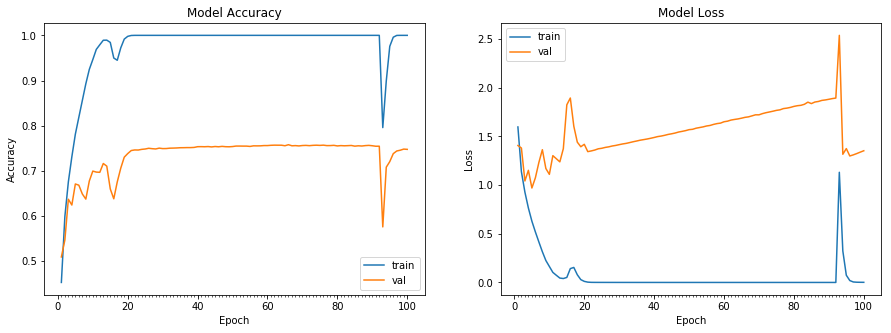

Accuracy on test data is: 74.77


In [12]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 256),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))